# Traveling Santa Prime Paths

---
[Problem In Kaggle](https://www.kaggle.com/c/traveling-santa-2018-prime-paths/)

---

### About Dataset

---
we are provided a list of cities and their coordinates in 'cities.csv'. goal is to create the shortest possible path that visits all the cities. Output should have the ordered list in which you visit each city. 

***Paths have the following constraints***:

- Paths must start and end at the North Pole (CityId = 0)
- You must visit every city exactly once.
- The distance between two paths is the 2D Euclidean distance, except...
  - Every 10th step (stepNumber % 10 == 0) is 10% more lengthy unless coming from a prime CityId.

---

design the representation of the candidate solutions, the implementation of genetic operators (crossover/mutation), and the design of the algorithm. Report the solution of your programs.


In [0]:
!pip install pyprind

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
from pandas import DataFrame
import random
import heapq
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from itertools import chain
from sympy import sieve

#--- setting the chunk size
import matplotlib as mpl

print(mpl.rcParams['agg.path.chunksize'])
mpl.rcParams['agg.path.chunksize'] = 10000
print(mpl.rcParams['agg.path.chunksize'])

10000
10000


In [0]:
dataURL = 'https://www.cs.odu.edu/~hpendyal/courses/cs580/project/data/cities.csv'
submissionURL = 'https://www.cs.odu.edu/~hpendyal/courses/cs580/project/data/sample_submission.csv'

In [0]:
#import data
df=pd.read_csv(dataURL)
df.head()

,CityId,X,Y
0,0,316.836739,2202.340707
1,1,4377.405972,336.602082
2,2,3454.158198,2820.053011
3,3,4688.099298,2935.898056
4,4,1010.696952,3236.750989


In [0]:
print('No of cities : ',len(df['CityId']))

No of cities :  197769


In [0]:
# using sieve of eratosthenes to find the prime numbers
def sieve_of_eratosthenes(n):
    primes = [True for i in range(n+1)] # Start assuming all numbers are primes
    primes[0] = False # 0 is not a prime
    primes[1] = False # 1 is not a prime
    for i in range(2,int(np.sqrt(n)) + 1):
        if primes[i]:
            k = 2
            while i*k <= n:
                primes[i*k] = False
                k += 1
    return(primes)
prime_cities = sieve_of_eratosthenes(max(df.CityId))

In [0]:
#--- Getting the prime city ids into seperate column isPrime
sieve.primerange(0, df.shape[0])

df['isPrime'] = prime_cities
df.head(15)

,CityId,X,Y,isPrime
0,0,316.836739,2202.340707,False
1,1,4377.405972,336.602082,False
2,2,3454.158198,2820.053011,True
3,3,4688.099298,2935.898056,True
4,4,1010.696952,3236.750989,False
5,5,2474.230877,1435.514651,True
6,6,1029.277795,2721.800952,False
7,7,3408.887685,199.585793,True
8,8,1304.006125,2657.427246,False
9,9,4211.525725,2294.595208,False


In [0]:
#no of prime cities
cities_prime = df[df['isPrime'] == True]
print('no of prime cities : ', len(cities_prime))

no of prime cities :  17802


In [0]:
cities_prime.head()

,CityId,X,Y,isPrime
2,2,3454.158198,2820.053011,True
3,3,4688.099298,2935.898056,True
5,5,2474.230877,1435.514651,True
7,7,3408.887685,199.585793,True
11,11,2052.116500,578.293526,True


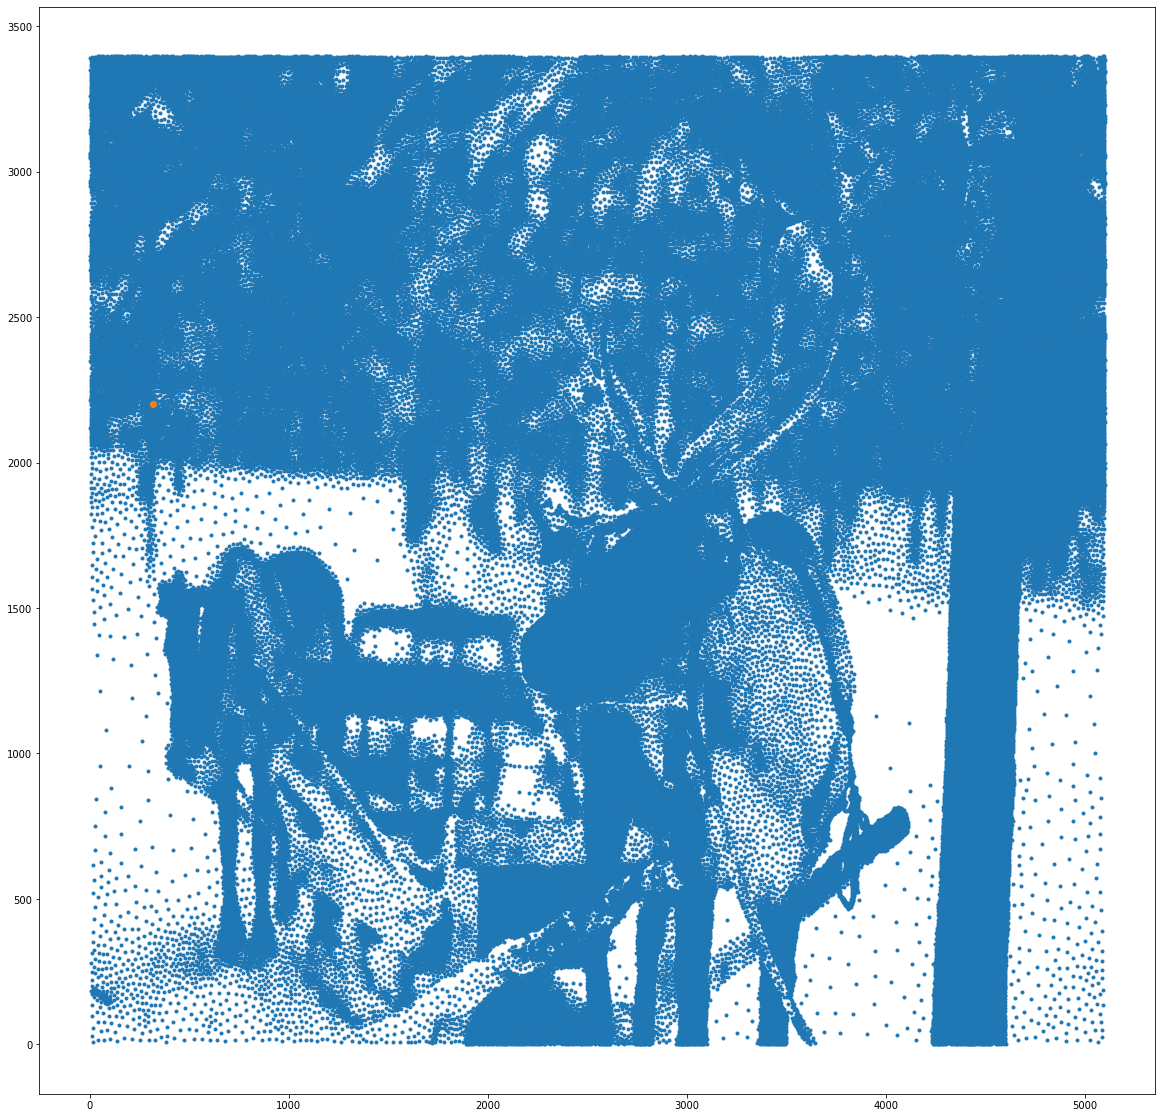

In [0]:
fig_dims = (20, 20)
fig, ax = plt.subplots(figsize=fig_dims)
plt.scatter(df['X'],df['Y'],marker='.')
plt.scatter(df[df['CityId'] == 0].X.astype(int), df[df['CityId'] == 0].Y.astype(int), marker='o', cmap='red')
# # save figure
# fig1 = plt.gcf()
# fig1.savefig('tessstttyyy.png')
plt.show()


So it looks like the cities are arranged in a reindeer pattern.

The red dot indicates the North Pole (CityId = 0).

Our task is to find a path that goes from the red dot, touches all the other dots, and comes back to the red-dot, with minimum total distance travelled !

### Dumbest Path 

visit every city in the CityID order and come back to the first city when we reach the end.

### Genetic Algorithm Approach

***Algorithm***

<p align="center">
<img src="https://media1.giphy.com/media/Aid095ixEDLS8/giphy.gif?cid=790b76119037c2b2f0388fc10810a62fdf9130a0b5f7a980&rid=giphy.gif"  height="450" />

In [0]:
from collections import Counter
def checkIfDuplicates(listOfElems):
    ''' Check if given list contains any duplicates '''
    dct = Counter(listOfElems)
    if max(dct.values()) > 1 and (dct[0] not in [1,2]):
      return True
    else:
      return False
    # if len(listOfElems) == len(set(listOfElems)):
    #   return False
    # else:
    #   return True

In [0]:
def total_distance(dfcity,path):
    prev_city = path[0]
    total_distance = 0
    step_num = 1
    for city_num in path[1:]:
        next_city = city_num
        total_distance = total_distance + np.sqrt(pow((dfcity.X[city_num] - dfcity.X[prev_city]),2) + pow((dfcity.Y[city_num] - dfcity.Y[prev_city]),2)) * (1+ 0.1*((step_num % 10 == 0)*int(not(prime_cities[prev_city]))))
        prev_city = next_city
        step_num = step_num + 1
    return total_distance

In [0]:
import datetime
def saveFile(data, filename):
  savepath = '/content/drive/My Drive/ODU/CourseWork/CS - 580 | F19 | Intro to Artificial Intelligence/project/outputs/'+filename
  data.to_csv(savepath)
  print('saved file : ',filename,' at - ',savepath)

In [0]:
def getDataFrame(data):
  #appends 0 at end of list then convert it to dataframe
  data.extend([0])
  labelsdf = pd.DataFrame(data = data, columns=['path'])
  return labelsdf

***As generating optimum path for all the nodes(197769) along with prime cities(17802) is difficult and time taking, to test the code we started from small subsets of 10, 25, 75, 100, 1000. results are saved in the drive.*** 

***For First 10 cities***

In [0]:
saveimgpath = '/content/drive/My Drive/ODU/CourseWork/CS - 580 | F19 | Intro to Artificial Intelligence/project/images/'
cities_10 = df.head(1000)
#--- .head(100000)
cities_10.head()

,CityId,X,Y,isPrime
0,0,316.836739,2202.340707,False
1,1,4377.405972,336.602082,False
2,2,3454.158198,2820.053011,True
3,3,4688.099298,2935.898056,True
4,4,1010.696952,3236.750989,False


In [0]:
%%time
cities_10_list = []
for i in range(0,len(cities_10)):
    cities_10_list.append((cities_10.iloc[i].X, cities_10.iloc[i].Y))

CPU times: user 318 ms, sys: 2 ms, total: 320 ms
Wall time: 326 ms


In [0]:
#--- sort the cities and then apply algorithm
sorted_cities = [0]
sorted_cities_df = cities_10.iloc[1:,].sort_values(['X','Y'])
new_row = pd.DataFrame({'CityId':0,'X': cities_10.iloc[0].X, 'Y': cities_10.iloc[0].Y,'isPrime':False}, index =[0])
sorted_cities_df = pd.concat([new_row, sorted_cities_df]).reset_index(drop = True) 
temp = list(cities_10.iloc[1:,].sort_values(['X','Y']).CityId)
sorted_cities.extend(temp)
sorted_cities_df.head()

,CityId,X,Y,isPrime
0,0,316.836739,2202.340707,False
1,865,11.440107,2769.676966,False
2,208,16.770012,2369.826016,False
3,897,21.114209,3384.441689,False
4,687,32.954917,2041.739128,False


In [0]:
%%time
sorted_cities_10 = []
for i in sorted_cities:
    sorted_cities_10.append((cities_10.iloc[i].X, cities_10.iloc[i].Y))

CPU times: user 327 ms, sys: 2 ms, total: 329 ms
Wall time: 332 ms


In [0]:
print('sorted cities : ',len(sorted_cities))
#sorted_path = [0]
dumbest_path = list(cities_10.CityId[:].append(pd.Series([0])))
sorted_path = list(sorted_cities_df.CityId[:].append(pd.Series([0])))
prime_cities_path = list(cities_prime.CityId[:])
print('unsorted Cities initial path : ',len(dumbest_path))
print('sorted Cities initial path : ',len(sorted_path))
print('Total distance with the dumbest path is '+ "{:,}".format(total_distance(cities_10,dumbest_path)))
print('Total distance with the sorted city path is '+ "{:,}".format(total_distance(cities_10,sorted_path)))
print('Total distance for prime cities : ',total_distance(cities_prime,prime_cities_path))

sorted cities :  1000
unsorted Cities initial path :  1001
sorted Cities initial path :  1001
Total distance with the dumbest path is 2,192,177.340869407
Total distance with the sorted city path is 969,250.0659356056
Total distance for prime cities :  39996421.01223912


In [0]:
import math
import matplotlib.colors

colors = ["salmon","mediumseagreen","navyx"]

class Graph:
    def __init__(self):
      self._cities = []
      self._vertices = []
      self._city_ids = []

    def __getitem__(self, idx):
      return self._cities[idx]

    def __setitem__(self, idx, value):
      self._cities[idx] = value

    def __len__(self):
      return len(self._cities)

    def append(self, city):
      #print(city.get_city_id())
      self._cities.append(city)
      self._vertices.append(city.getVertex())
      self._city_ids.append(city.get_city_id())
        
    def get_cities(self):
      return self._cities

    def get_vertices(self):
      return self._vertices

    def get_city_ids(self):
      return self._city_ids

    @staticmethod
    def euclidean_distance(coord1, coord2):
      return math.sqrt((coord2[0] - coord1[0]) ** 2 + (coord2[1] - coord1[1]) ** 2)

    def plot(self,tour=None,text=None):
      if tour is None:
        tour = Tour(self)
      _path = [self.get_cities()[0].get_city_id()]
      _vertices = [self.get_vertices()[0]]

      for i in tour.vertices:
        _vertices.append(self.get_vertices()[i])
        _path.append(self.get_cities()[i].get_city_id())

      _vertices.append(self.get_vertices()[0])
      _path.append(self.get_cities()[0].get_city_id())
      print('vertices : ',len(_vertices))
      plt.figure(figsize=(10,10))
      plt.title("Cost = " + str(tour.fitness()))
      plt.plot(*zip(*_vertices), '-r', linewidth=1, alpha=0.3)
      plt.scatter(*zip(*self.get_vertices()), color="mediumseagreen", s=10, marker="s")
      plt.plot(cities_10['X'][0], cities_10['Y'][0], marker='x', color='navy')
      #print('vertices co-ordinates : ',_vertices)
      print('Path : ',len(_path))
      #--- save image
      dt = '{date:%Y%m%d_%H%M%S}_'.format(date=datetime.datetime.now())
      filename = dt+str(len(tour.path()))+'_'+text+'_paths.csv'
      image_name = saveimgpath+dt+str(len(_path))+'_'+text+'_paths.png'
      fig1 = plt.gcf()
      # fig1.savefig(image_name) #---- commented as giving a huge load on colab
      plt.show()
      if checkIfDuplicates(_path):
        print('ERROR !! ---- Yes, There are Duplicates')
        data_df = getDataFrame(_path)
        saveFile(data_df, filename)
        #DataFrame.to_csv(savepath+str(tour.fitness())+'_'+str(len(tour.path()))+'.txt')
      else:
        print('HURRAY!!!!---- There are NO Duplicates in the path')
        data_df = getDataFrame(tour.path())
        saveFile(data_df, filename)  

class City:
    def __init__(self, city_id, x, y):
        self._city_id = city_id
        self._x = x
        self._y = y
        self._visited = False
        self._vertex = (x,y)

    def getX(self):
        return self._x

    def getY(self):
        return self._y

    def get_city_id(self):
        return self._city_id

    def getVertex(self):
        return self._vertex

    def visit(self):
        self._visited = True

    def is_visited(self):
        return self._visited

    def __eq__(self, other):
        if not isinstance(other, type(self)):
            return False
        return self._city_id == other.get_city_id()

    def __hash__(self):
        return hash(self._city_id)

In [0]:
class Tour:
    def __init__(self, g, vertices = None):
        """Generate random tour in given graph g"""
        self.g = g
        self.__path = []
        if vertices is None:
            self.vertices = list(range(1,len(g.get_vertices())))
            #self.__path = g.get_city_ids()
            #random.shuffle(self.vertices)
        else:
            self.vertices = vertices
            #self.__path = g.get_city_ids()
        #print(self.vertices)
        self.__cost = None
        self.__fitness = None
    def path(self):
      return self.__path
    def cost(self):
        """Return total edge-cost of tour"""
        if self.__cost is None:
            self.__cost = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
                self.__cost += self.g.euclidean_distance(self.g.get_vertices()[i], self.g.get_vertices()[j])
        return self.__cost
    def fitness(self):
        """Return total edge-cost of tour"""
        if self.__fitness is None:
            prev_city = 0
            step_num = 1
            self.__path.append(prev_city)
            self.__fitness = 0
            for i, j in zip([0] + self.vertices, self.vertices + [0]):
              next_city = j
              #print(j)
              self.__fitness += self.g.euclidean_distance(self.g.get_vertices()[i], self.g.get_vertices()[j]) * (1+ 0.1*((step_num % 10 == 0)*int(not(prime_cities[prev_city]))))
              prev_city = next_city
              self.__path.append(self.g.get_city_ids()[j])
              step_num = step_num + 1
        return self.__fitness

---- Initial prime cities Unsorted Array ----
vertices :  17803
Path :  17803


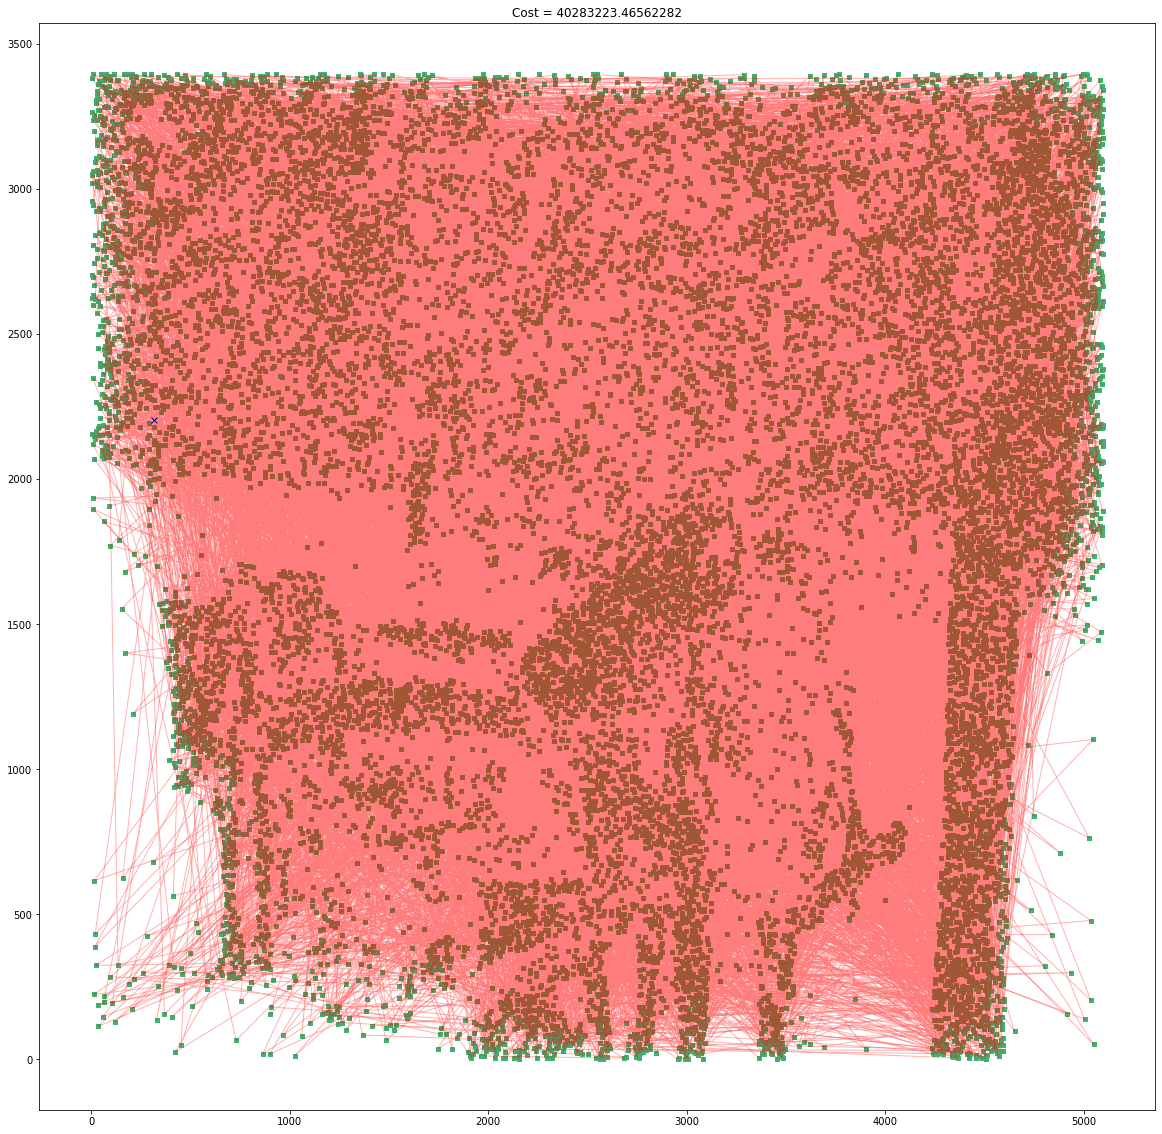

ERROR !! ---- Yes, There are Duplicates
saved file :  20191210_155140_17803_prime_cities_unsorted_paths.csv  at -  /content/drive/My Drive/ODU/CourseWork/CS - 580 | F19 | Intro to Artificial Intelligence/project/outputs/20191210_155140_17803_prime_cities_unsorted_paths.csv
CPU times: user 8.19 s, sys: 860 ms, total: 9.05 s
Wall time: 9.02 s


In [0]:
%%time
prime_graph = Graph()
for i in cities_prime.CityId:
  prime_graph.append(City(cities_prime['CityId'][i], cities_prime['X'][i], cities_prime['Y'][i]))
print('---- Initial prime cities Unsorted Array ----')
prime_graph.plot(text='prime_cities_unsorted')


---- Initial Unsorted Array ----
vertices :  1001
Path :  1001


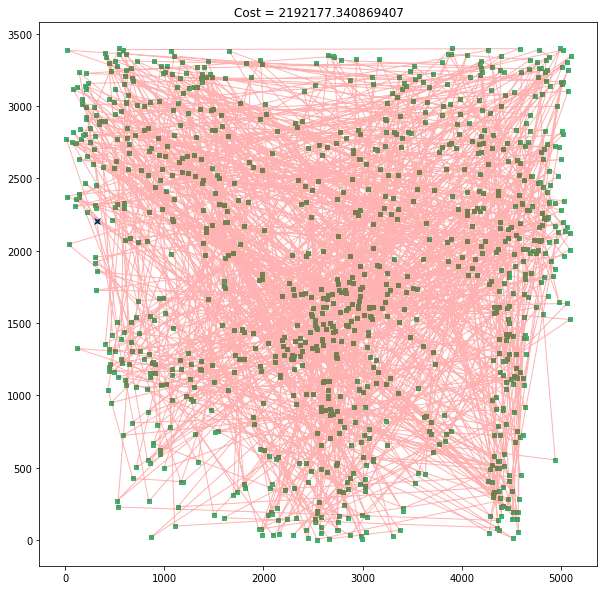

HURRAY!!!!---- There are NO Duplicates in the path
saved file :  20191210_223452_1001_100000_unsorted_paths.csv  at -  /content/drive/My Drive/ODU/CourseWork/CS - 580 | F19 | Intro to Artificial Intelligence/project/outputs/20191210_223452_1001_100000_unsorted_paths.csv
CPU times: user 634 ms, sys: 111 ms, total: 745 ms
Wall time: 647 ms


In [0]:
%%time
graph = Graph()
for i in range(0, len(cities_10)):
  graph.append(City(cities_10['CityId'][i], cities_10['X'][i], cities_10['Y'][i]))
#a = graph.get_cities()
# print(len(graph))
# print(graph.get_vertices()[0])
# print(graph.get_cities()[0].get_city_id())
# print(graph[0].getVertex())
print('---- Initial Unsorted Array ----')
graph.plot(text='100000_unsorted')

---- Initial sorted Array ----
vertices :  1001
Path :  1001


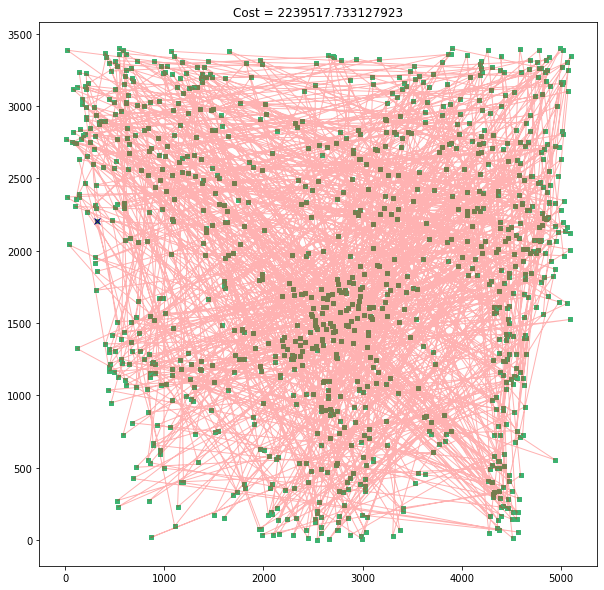

HURRAY!!!!---- There are NO Duplicates in the path
saved file :  20191210_223512_1001_1000000_initial_sorted_paths.csv  at -  /content/drive/My Drive/ODU/CourseWork/CS - 580 | F19 | Intro to Artificial Intelligence/project/outputs/20191210_223512_1001_1000000_initial_sorted_paths.csv
CPU times: user 636 ms, sys: 103 ms, total: 739 ms
Wall time: 633 ms


In [0]:
%%time
graph_b = Graph()
for i in sorted_cities:
  graph_b.append(City(sorted_cities_df['CityId'][i], sorted_cities_df['X'][i], sorted_cities_df['Y'][i]))
#print(graph.get_city_ids())
print('---- Initial sorted Array ----')
graph_b.plot(text='1000000_initial_sorted')

### Ordered Crossover
- Idea is to preserve the relative order that elements occur
- Procedure
    1. choose a random part from first parent
    2. copy this part to the first child
    3. Copy the numbers that are not in the first part, to the first child.
        - start right from cut point of the copied part,
        - using the order of the second parent
        - and wrapping around the end
    4. Analogous for the first child, with parent roles are reversed.

![ordered-crossover](https://www.cs.odu.edu/~hpendyal/courses/cs580/project/images/ordered-crossover-example.PNG)

In [0]:
class GeneticAlgorithm:

    def __init__(self, g, population_size, k=5, elite_mating_rate=0.5,
                 mutation_rate=0.015, mutation_swap_rate=0.2):
        """Initialises algorithm parameters"""

        self.g = g

        self.population = []
        for _ in range(population_size):
            self.population.append(Tour(g))

        self.population_size = population_size
        self.k = k
        self.elite_mating_rate = elite_mating_rate
        self.mutation_rate = mutation_rate
        self.mutation_swap_rate = mutation_swap_rate

    def crossover(self, mum, dad):
        """Implements ordered crossover"""

        size = len(mum.vertices)

        # Choose random start/end position for crossover
        alice, bob = [-1] * size, [-1] * size
        start, end = sorted([random.randrange(size) for _ in range(2)])

        # Replicate mum's sequence for alice, dad's sequence for bob
        for i in range(start, end + 1):
            alice[i] = mum.vertices[i]
            bob[i] = dad.vertices[i]

        # Fill the remaining position with the other parents' entries
        current_dad_position, current_mum_position = 0, 0

        for i in chain(range(start), range(end + 1, size)):

            while dad.vertices[current_dad_position] in alice:
                current_dad_position += 1

            while mum.vertices[current_mum_position] in bob:
                current_mum_position += 1

            alice[i] = dad.vertices[current_dad_position]
            bob[i] = mum.vertices[current_mum_position]

        # Return twins
        return Tour(self.g, alice), Tour(self.g, bob)

    def mutate(self, tour):
        """Randomly swaps pairs of cities in a given tour according to mutation rate"""

        # Decide whether to mutate
        if random.random() < self.mutation_rate:

            # For each vertex
            for i in range(len(tour.vertices)):

                # Randomly decide whether to swap
                if random.random() < self.mutation_swap_rate:

                    # Randomly choose other city position
                    j = random.randrange(len(tour.vertices))

                    # Swap
                    tour.vertices[i], tour.vertices[j] = tour.vertices[j], tour.vertices[i]

    def select_parent(self, k):
        """Implements k-tournament selection to choose parents"""
        tournament = random.sample(self.population, k)
        return max(tournament, key=lambda t: t.cost())

    def evolve(self):
        """Executes one iteration of the genetic algorithm to obtain a new generation"""

        new_population = []

        for _ in range(self.population_size):

            # K-tournament for parents
            mum, dad = self.select_parent(self.k), self.select_parent(self.k)
            alice, bob = self.crossover(mum, dad)

            # Mate in an elite fashion according to the elitism_rate
            if random.random() < self.elite_mating_rate:
                if alice.cost() < mum.cost() or alice.cost() < dad.cost():
                    new_population.append(alice)
                if bob.cost() < mum.cost() or bob.cost() < dad.cost():
                    new_population.append(bob)

            else:
                self.mutate(alice)
                self.mutate(bob)
                new_population += [alice, bob]

        # Add new population to old
        self.population += new_population

        # Retain fittest
        self.population = heapq.nsmallest(self.population_size, self.population, key=lambda t: t.fitness())

#--- 5000
    def run(self, iterations=500):
        for _ in range(iterations):
            self.evolve()

    def best(self):
        return min(self.population, key=lambda t: t.fitness())

vertices :  17804
Path :  17804


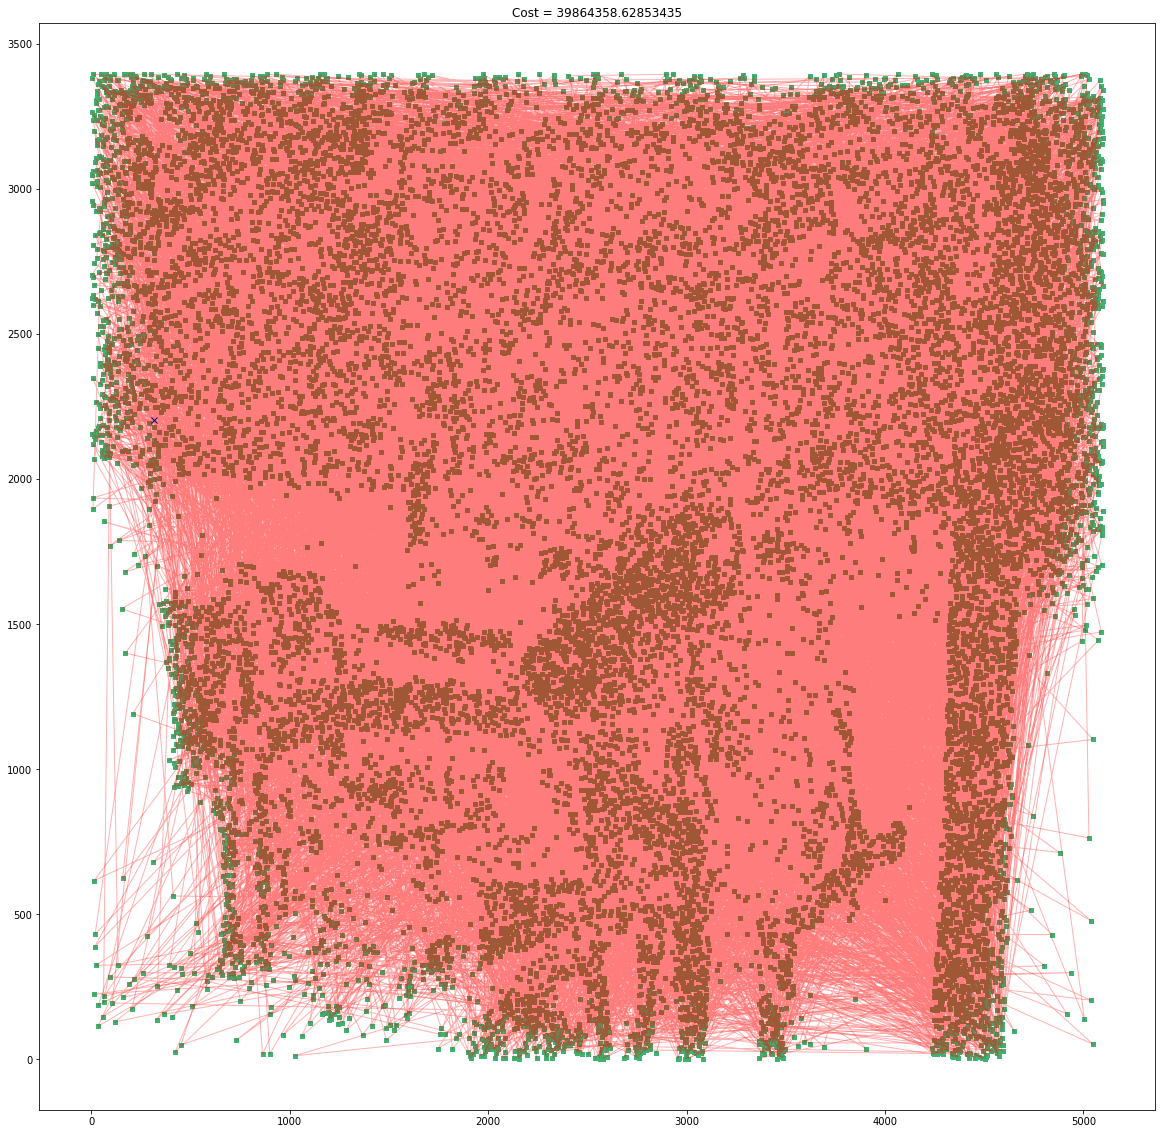

ERROR !! ---- Yes, There are Duplicates
saved file :  20191210_204722_17804_final_primeCities_all_paths.csv  at -  /content/drive/My Drive/ODU/CourseWork/CS - 580 | F19 | Intro to Artificial Intelligence/project/outputs/20191210_204722_17804_final_primeCities_all_paths.csv
CPU times: user 4h 52min 49s, sys: 2.24 s, total: 4h 52min 51s
Wall time: 4h 53min 5s


In [0]:
%%time
#--- run and find the shortest distance between all prime cities
graph_p = Graph()
graph_p.append(City(cities_10['CityId'][i], cities_10['X'][i], cities_10['Y'][i]))#--- append the starting city first
for i in cities_prime.CityId:
  graph_p.append(City(cities_prime['CityId'][i], cities_prime['X'][i], cities_prime['Y'][i]))

g = graph_p

ga = GeneticAlgorithm(g,50)
ga.run()

best_tour = ga.best()
g.plot(best_tour, text='final_primeCities_all')

vertices :  1001
Path :  1001


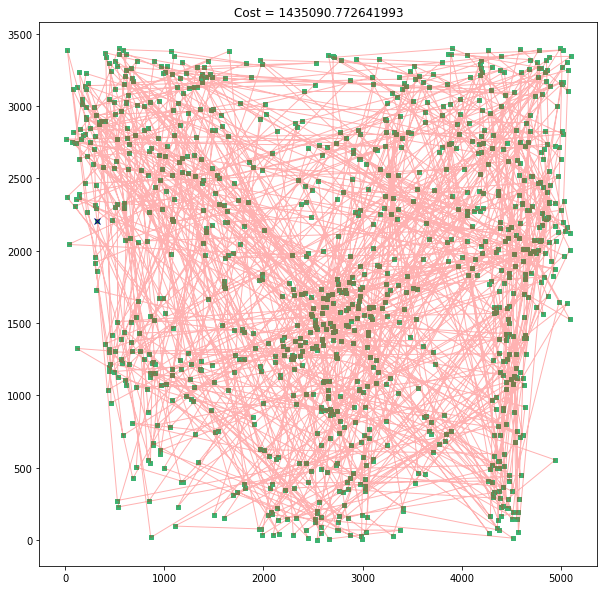

HURRAY!!!!---- There are NO Duplicates in the path
saved file :  20191210_233906_1001_final_unsorted_250_500_paths.csv  at -  /content/drive/My Drive/ODU/CourseWork/CS - 580 | F19 | Intro to Artificial Intelligence/project/outputs/20191210_233906_1001_final_unsorted_250_500_paths.csv
CPU times: user 1h 3min 43s, sys: 525 ms, total: 1h 3min 43s
Wall time: 1h 3min 46s


In [0]:
%%time
#--- running on given first 10 cities
graph = Graph()
for i in range(0, len(cities_10)):
  graph.append(City(cities_10['CityId'][i], cities_10['X'][i], cities_10['Y'][i]))

g = graph

ga = GeneticAlgorithm(g, 250)
ga.run()

best_tour = ga.best()
g.plot(best_tour, text='final_unsorted_250_500')

In [0]:
%%time
#--- running on given first 10 sorted cities
graph = Graph()
for i in sorted_cities:
  graph.append(City(sorted_cities_df['CityId'][i], sorted_cities_df['X'][i], sorted_cities_df['Y'][i]))
g = graph

ga = GeneticAlgorithm(g, 250)
ga.run()

best_tour = ga.best()
g.plot(best_tour, text='final_sorted')

### References
1. https://www.rookieslab.com/posts/fastest-way-to-check-if-a-number-is-prime-or-not
2. https://github.com/jessiejc23/travelling-santa-2018/blob/master/v3.0%20GA.ipynb
3. https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
4. https://github.com/LazoCoder/Genetic-Algorithm-for-the-Traveling-Salesman-Problem
5. https://github.com/hechmik/travelling_santa_metaheuristics/blob/master/all_steps_GA.ipynb
6. https://github.com/RubenBranco/Travelling-Santa-2018/blob/master/Search.py
7. https://github.com/mrtovsky/Kaggle-competition/tree/master/Traveling-Santa-2018
8. https://github.com/ezstoltz/genetic-algorithm/blob/master/genetic_algorithm_TSP.ipynb

### Observations 

- when the algorithm is appllied for the first 10 cities we can see that both sorted and unsorted cities gives the same result

### ROUGH

In [0]:
%%time
# Test on berlin52: http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/berlin52.tsp

tsp = [(565.0, 575.0), (25.0, 185.0), (345.0, 750.0), (945.0, 685.0), 
           (845.0, 655.0), (880.0, 660.0), (25.0, 230.0), (525.0, 1000.0), 
           (580.0, 1175.0), (650.0, 1130.0), (1605.0, 620.0), (1220.0, 580.0), 
           (1465.0, 200.0), (1530.0, 5.0), (845.0, 680.0), (725.0, 370.0), 
           (145.0, 665.0), (415.0, 635.0), (510.0, 875.0), (560.0, 365.0), 
           (300.0, 465.0), (520.0, 585.0), (480.0, 415.0), (835.0, 625.0), 
           (975.0, 580.0), (1215.0, 245.0), (1320.0, 315.0), (1250.0, 400.0), 
           (660.0, 180.0), (410.0, 250.0), (420.0, 555.0), (575.0, 665.0), 
           (1150.0, 1160.0), (700.0, 580.0), (685.0, 595.0), (685.0, 610.0), 
           (770.0, 610.0), (795.0, 645.0), (720.0, 635.0), (760.0, 650.0), 
           (475.0, 960.0), (95.0, 260.0), (875.0, 920.0), (700.0, 500.0), 
           (555.0, 815.0), (830.0, 485.0), (1170.0, 65.0), (830.0, 610.0), 
           (605.0, 625.0), (595.0, 360.0), (1340.0, 725.0), (1740.0, 245.0)]

graph = Graph()
for i in range(0, len(tsp)):
  graph.append(City(i, tsp[i][0], tsp[i][1]))

g = graph

ga = GeneticAlgorithm(g, 100)
ga.run()

best_tour = ga.best()
g.plot(best_tour)# This Python 3 environment comes with many helpful analytics libraries installed